# Autoencoders

# 2 types of autoencoders to try

important note cant run the code sequentially since x_train and x_val x_test change throughout the code so need to run the split cell and the scale cell before running any autoencode w/o smote and for the one with smote run the splitting cell then the code that section bec we scale after applying smote sorry if its a bit complicated..
1. Vanilla (one layer) autoencoders 
2. Multilayer autoencoder

**all with softmax to classify
without smote just standardised the dataset using StandardScaler fitting it only on the training data to prevent data leakage and then applying the same transformation to the validation and test set

SMOTE gave a slightly better result 52% (f-score)
**The code with smote repeats the same preprocessing technique as before with the scaling^^ so to run that section you would need to run the import libraries then the cell below it then the code in the smote section no need to runn all cells since it will scale again 

## Import the libraries

In [88]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler

## Load the data

We don't need the labels as the autoencoders are unsupervised network

## Preprocess (need to rerun this cell and the one below it for each autoencoder since x_train changes throughout code)

# splitting cell 

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = r'C:\Users\l_alm\resnet1d-master\content\customerTargeting.csv'
df = pd.read_csv(data)
X = df.drop(columns=["target"])
y=df["target"]

# 80% (train + validation) and 20% (test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 60% (train) and 20% (validation) from the 80% data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42,stratify=y_train_val)


#the final sizes
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")




Train: 3972, Validation: 1324, Test: 1324


# scaling cell

# If you're going to run SMOTE section please dont run this cell below

In [90]:
scaler = StandardScaler()
scaler.fit(X_train)  # Fit only on training data

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)  # Apply same transformation
X_test = scaler.transform(X_test)  # Apply same transformation


# **Vanilla Autoencoder**

### Create the network

The first network is the most simple autoencoder. It has three layers Input - encoder - decoder

In [4]:
input_size = 70
hidden_size = 1000
bottleneck_size = 1000
output_size = 70

In [5]:


input_layer = Input(shape=(input_size,))

encoder = Dense(hidden_size, activation="relu")(input_layer)


bottleneck = Dense(bottleneck_size, activation="relu")(encoder) 


decoder = Dense(hidden_size, activation="relu")(bottleneck)

output_layer = Dense(input_size, activation="sigmoid")(decoder)  

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse') 

### Train

In [6]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=128, validation_data=(X_val, X_val), shuffle=True, callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 1s 27ms/step - loss: 1.0467 - val_loss: 0.8164
Epoch 2/200
32/32 [==============================] - 1s 21ms/step - loss: 0.7479 - val_loss: 0.6883
Epoch 3/200
32/32 [==============================] - 1s 20ms/step - loss: 0.6804 - val_loss: 0.6540
Epoch 4/200
32/32 [==============================] - 1s 22ms/step - loss: 0.6513 - val_loss: 0.6261
Epoch 5/200
32/32 [==============================] - 1s 20ms/step - loss: 0.6277 - val_loss: 0.6063
Epoch 6/200
32/32 [==============================] - 1s 24ms/step - loss: 0.6107 - val_loss: 0.5929
Epoch 7/200
32/32 [==============================] - 1s 20ms/step - loss: 0.5996 - val_loss: 0.5841
Epoch 8/200
32/32 [==============================] - 1s 20ms/step - loss: 0.5923 - val_loss: 0.5781
Epoch 9/200
32/32 [==============================] - 1s 21ms/step - loss: 0.5869 - val_loss: 0.5736
Epoch 10/200
32/32 [==============================] - 1s 21ms/step - loss: 0.5829 - val_loss: 0.5702

### Predict on the test set

In [7]:
decoded = autoencoder.predict(X_test)

42/42 [==============================] - 0s 6ms/step


### Plot

### Plot the losses

dict_keys(['loss', 'val_loss'])


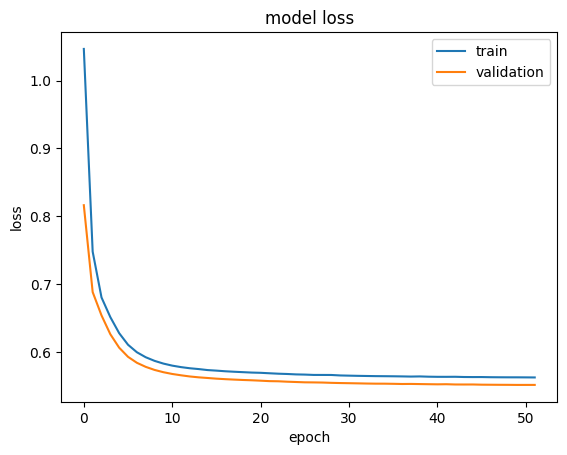

In [8]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [9]:
from keras.models import Model

#extracting encoder part from trained autoencoder
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=2).output)  #bottleneck layer


In [10]:
X_train_encoded = encoder_model.predict(X_train)
X_val_encoded = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test)

42/42 [==============================] - 0s 3ms/step


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

#defining a classifier using the encoded features
classifier = Sequential([
    Dense(3, activation="softmax" ) #output layer (3 classes)
     ])

# Compile the classifier
classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')


In [12]:



#compute class weights
#class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))} improves performance in classes 0 and 2 but lowers the performance
#print("class Weights:", class_weights_dict)
# Train classifier
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 
history=classifier.fit(X_train_encoded, y_train, epochs=200, batch_size=128, validation_data=(X_val_encoded, y_val), shuffle=True, callbacks=[early_stopping], )



Epoch 1/200
32/32 [==============================] - 1s 8ms/step - loss: 1.3015 - val_loss: 1.1041
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0828 - val_loss: 1.0448
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0465 - val_loss: 1.0237
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 1.0239 - val_loss: 1.0062
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0079 - val_loss: 0.9940
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9966 - val_loss: 0.9846
Epoch 7/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9874 - val_loss: 0.9783
Epoch 8/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9788 - val_loss: 0.9729
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9746 - val_loss: 0.9687
Epoch 10/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9701 - val_loss: 0.9657
Epoch 11/

dict_keys(['loss', 'val_loss'])


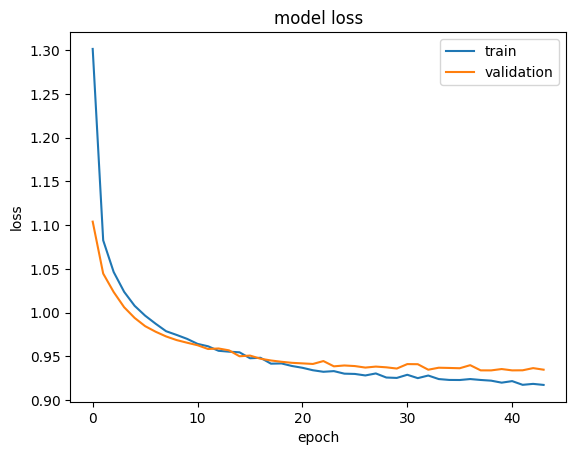

In [13]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [14]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test_encoded)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))


42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.3505    0.1021    0.1581       333
           1     0.5990    0.8114    0.6892       615
           2     0.5660    0.5931    0.5792       376

    accuracy                         0.5710      1324
   macro avg     0.5052    0.5022    0.4755      1324
weighted avg     0.5271    0.5710    0.5244      1324



---

# **Multilayer autoencoder**

trying 2 layers 

In [78]:
input_size = 70
hidden_size1= 1000
hidden_size2= 1000
bottleneck_size= 1000
output_size = 70

input_layer = Input(shape=(input_size,))
encoder = Dense(hidden_size1, activation="relu")(input_layer)
encoder = Dense(hidden_size2, activation="relu")(encoder)
bottleneck = Dense(bottleneck_size, activation="relu")(encoder)  


decoder = Dense(hidden_size2, activation="relu")(bottleneck)
decoder = Dense(hidden_size1, activation="relu")(decoder)
output_layer = Dense(output_size, activation="sigmoid")(decoder) 

autoencoder2 = Model(inputs=input_layer, outputs=output_layer)
autoencoder2.compile(Adam(learning_rate=1e-4), loss='mse')

### Train the network

In [79]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder2.fit(X_train, X_train, batch_size=128, epochs=200, verbose=1, validation_data=(X_val, X_val), shuffle=True,callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 2s 44ms/step - loss: 1.0273 - val_loss: 0.7661
Epoch 2/200
32/32 [==============================] - 1s 38ms/step - loss: 0.7195 - val_loss: 0.6777
Epoch 3/200
32/32 [==============================] - 1s 39ms/step - loss: 0.6806 - val_loss: 0.6616
Epoch 4/200
32/32 [==============================] - 1s 38ms/step - loss: 0.6610 - val_loss: 0.6397
Epoch 5/200
32/32 [==============================] - 1s 41ms/step - loss: 0.6404 - val_loss: 0.6216
Epoch 6/200
32/32 [==============================] - 1s 40ms/step - loss: 0.6248 - val_loss: 0.6083
Epoch 7/200
32/32 [==============================] - 1s 40ms/step - loss: 0.6123 - val_loss: 0.5982
Epoch 8/200
32/32 [==============================] - 1s 40ms/step - loss: 0.6044 - val_loss: 0.5907
Epoch 9/200
32/32 [==============================] - 1s 42ms/step - loss: 0.5982 - val_loss: 0.5863
Epoch 10/200
32/32 [==============================] - 1s 38ms/step - loss: 0.5946 - val_loss: 0.5855

### Predict on the test set

In [80]:
decoded_output= autoencoder2.predict(X_test)

42/42 [==============================] - 1s 10ms/step


### Plot the losses

dict_keys(['loss', 'val_loss'])


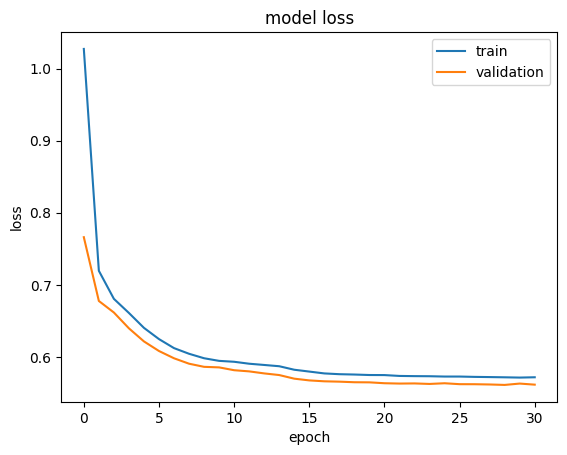

In [81]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [82]:
encoder_model = Model(inputs=autoencoder2.input, outputs=autoencoder2.get_layer(index=3).output)  #bottleneck layer

In [83]:
X_train_encoded = encoder_model.predict(X_train)
X_val_encoded = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test)

42/42 [==============================] - 0s 5ms/step


In [84]:
#defining a classifier using the encoded features
classifier = Sequential([
    Dense(3, activation="softmax")  #output layer (3 classes)
])

# Compile the classifier
classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')


In [85]:

#compute class weights
#class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))} improves performance in classes 0 and 2 but lowers the performance
#print("class Weights:", class_weights_dict)
# Train classifier
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 
history=classifier.fit(X_train_encoded, y_train, epochs=200, batch_size=128, validation_data=(X_val_encoded, y_val), shuffle = True,callbacks=[early_stopping])



Epoch 1/200
32/32 [==============================] - 0s 6ms/step - loss: 1.2656 - val_loss: 1.1518
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 1.1309 - val_loss: 1.0818
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0683 - val_loss: 1.0411
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0316 - val_loss: 1.0214
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 1.0101 - val_loss: 1.0028
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9942 - val_loss: 0.9903
Epoch 7/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9828 - val_loss: 0.9829
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9707 - val_loss: 0.9767
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9630 - val_loss: 0.9682
Epoch 10/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9616 - val_loss: 0.9637
Epoch 11/

# plot

dict_keys(['loss', 'val_loss'])


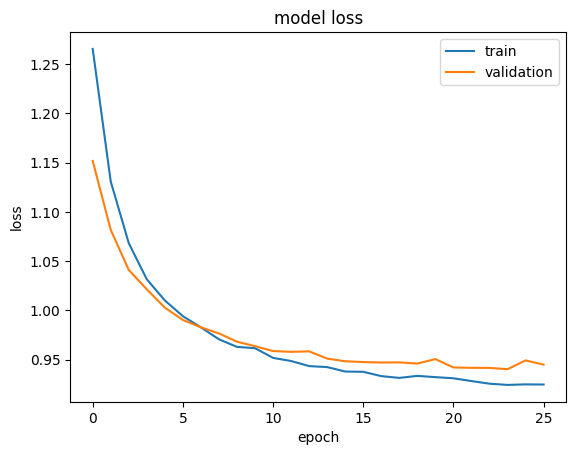

In [86]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [87]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test_encoded)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))

42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.3211    0.1051    0.1584       333
           1     0.5908    0.7935    0.6773       615
           2     0.5656    0.5851    0.5752       376

    accuracy                         0.5612      1324
   macro avg     0.4925    0.4946    0.4703      1324
weighted avg     0.5158    0.5612    0.5178      1324



# Trying 3 layers

In [96]:

input_size = 70
hidden_size1 = 1000
hidden_size2 = 1000
hidden_size3 = 1000
bottleneck_size = 1000
output_size = 70

input_layer = Input(shape=(input_size,))


encoder = Dense(hidden_size1, activation="relu")(input_layer)
encoder = Dense(hidden_size2, activation="relu")(encoder)
encoder = Dense(hidden_size3, activation="relu")(encoder)
bottleneck = Dense(bottleneck_size, activation="relu")(encoder)  # Bottleneck layer

#decoder with 3 hidden layers
decoder = Dense(hidden_size3, activation="relu")(bottleneck)
decoder = Dense(hidden_size2, activation="relu")(decoder)
decoder = Dense(hidden_size1, activation="relu")(decoder)
output_layer = Dense(output_size, activation="sigmoid")(decoder)  # Final output layer

#defining the Autoencoder model
autoencoder3 = Model(inputs=input_layer, outputs=output_layer)

#compile the model
autoencoder3.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')


In [97]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder3.fit(X_train, X_train, batch_size=128, epochs=200, verbose=1, validation_data=(X_val, X_val), shuffle=True,callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 3s 61ms/step - loss: 1.0227 - val_loss: 0.7793
Epoch 2/200
32/32 [==============================] - 2s 58ms/step - loss: 0.7379 - val_loss: 0.6941
Epoch 3/200
32/32 [==============================] - 2s 62ms/step - loss: 0.7005 - val_loss: 0.6828
Epoch 4/200
32/32 [==============================] - 2s 63ms/step - loss: 0.6896 - val_loss: 0.6691
Epoch 5/200
32/32 [==============================] - 2s 63ms/step - loss: 0.6737 - val_loss: 0.6602
Epoch 6/200
32/32 [==============================] - 2s 61ms/step - loss: 0.6615 - val_loss: 0.6452
Epoch 7/200
32/32 [==============================] - 2s 57ms/step - loss: 0.6480 - val_loss: 0.6285
Epoch 8/200
32/32 [==============================] - 2s 56ms/step - loss: 0.6310 - val_loss: 0.6120
Epoch 9/200
32/32 [==============================] - 2s 57ms/step - loss: 0.6172 - val_loss: 0.6022
Epoch 10/200
32/32 [==============================] - 2s 54ms/step - loss: 0.6091 - val_loss: 0.5976

# Plot

dict_keys(['loss', 'val_loss'])


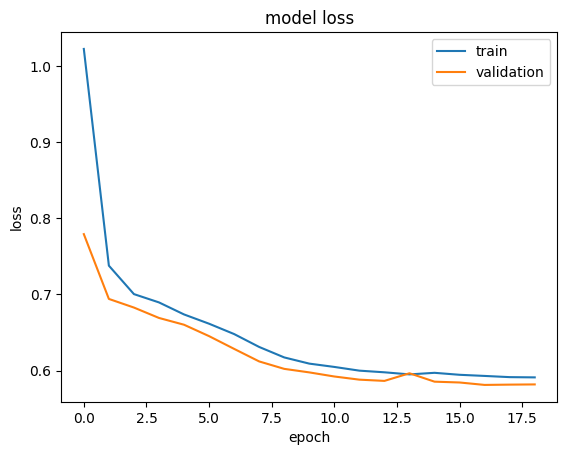

In [98]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Classification

In [99]:
encoder_model = Model(inputs=autoencoder3.input, outputs=autoencoder3.get_layer(index=4).output)

In [100]:
X_train_encoded = encoder_model.predict(X_train)
X_val_encoded = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test)

42/42 [==============================] - 0s 7ms/step


In [101]:

classifier = Sequential([
    Dense(3, activation="softmax")  #output layer (3 classes)
])

#compiling the classifier
classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')


In [102]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history=classifier.fit(X_train_encoded, y_train, epochs=200, batch_size=128, validation_data=(X_val_encoded, y_val), shuffle = True,callbacks=[early_stopping])


Epoch 1/200
32/32 [==============================] - 1s 8ms/step - loss: 1.2101 - val_loss: 1.1146
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 1.0873 - val_loss: 1.0749
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 1.0471 - val_loss: 1.0444
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 1.0190 - val_loss: 1.0225
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 1.0006 - val_loss: 1.0071
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9836 - val_loss: 0.9972
Epoch 7/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9743 - val_loss: 0.9872
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9665 - val_loss: 0.9843
Epoch 9/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9571 - val_loss: 0.9740
Epoch 10/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9512 - val_loss: 0.9673
Epoch 11/

# Plot

dict_keys(['loss', 'val_loss'])


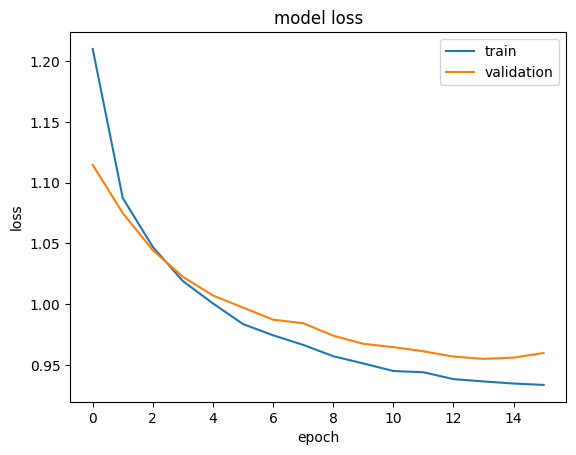

In [103]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Test

In [104]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test_encoded)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))

42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.3673    0.0541    0.0942       333
           1     0.5805    0.8211    0.6801       615
           2     0.5185    0.5585    0.5378       376

    accuracy                         0.5536      1324
   macro avg     0.4888    0.4779    0.4374      1324
weighted avg     0.5093    0.5536    0.4923      1324



In [ ]:
#############################################################################################################################################################################################

# SMOTE with Simple Autoencoder
you need to run the import cell and the first cell at the beginning then run the cell below for preprocessing 


In [65]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np


print("Original class distribution:", Counter(y_train))

#apply only on minority which is class 0
smote = SMOTE(sampling_strategy='minority', random_state=42) 
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# class distribution after SMOTE
print("Resampled class distribution:", Counter(y_train_resampled))



scaler = StandardScaler()
scaler.fit(X_train_resampled)

X_train_resampled = scaler.transform(X_train_resampled)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


Original class distribution: Counter({1: 1846, 2: 1126, 0: 1000})
Resampled class distribution: Counter({0: 1846, 1: 1846, 2: 1126})


In [66]:
input_size = 70
hidden_size = 1000
bottleneck_size = 1000 
output_size = 70

In [67]:

input_layer = Input(shape=(input_size,))

encoder = Dense(hidden_size, activation="relu")(input_layer)


bottleneck = Dense(bottleneck_size, activation="relu")(encoder) 


decoder = Dense(hidden_size, activation="relu")(bottleneck)

output_layer = Dense(input_size, activation="sigmoid")(decoder)  

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

In [68]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder.fit(X_train_resampled, X_train_resampled, epochs=200, batch_size=128, validation_data=(X_val, X_val),shuffle=True, callbacks=[early_stopping])

Epoch 1/200
38/38 [==============================] - 2s 28ms/step - loss: 1.0097 - val_loss: 0.7945
Epoch 2/200
38/38 [==============================] - 1s 23ms/step - loss: 0.7135 - val_loss: 0.6947
Epoch 3/200
38/38 [==============================] - 1s 21ms/step - loss: 0.6598 - val_loss: 0.6564
Epoch 4/200
38/38 [==============================] - 1s 22ms/step - loss: 0.6294 - val_loss: 0.6306
Epoch 5/200
38/38 [==============================] - 1s 21ms/step - loss: 0.6097 - val_loss: 0.6141
Epoch 6/200
38/38 [==============================] - 1s 22ms/step - loss: 0.5971 - val_loss: 0.6040
Epoch 7/200
38/38 [==============================] - 1s 21ms/step - loss: 0.5893 - val_loss: 0.5974
Epoch 8/200
38/38 [==============================] - 1s 22ms/step - loss: 0.5840 - val_loss: 0.5930
Epoch 9/200
38/38 [==============================] - 1s 22ms/step - loss: 0.5805 - val_loss: 0.5898
Epoch 10/200
38/38 [==============================] - 1s 23ms/step - loss: 0.5780 - val_loss: 0.5877

# Plot

dict_keys(['loss', 'val_loss'])


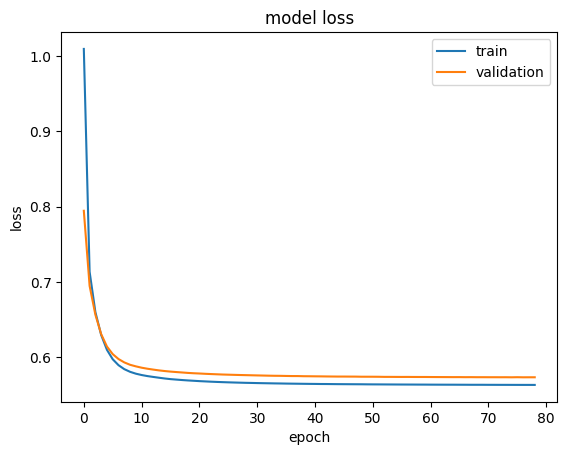

In [69]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# Classification with softmax

In [70]:
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=2).output)

In [71]:
X_train_encoded = encoder_model.predict(X_train_resampled)
X_val_encoded = encoder_model.predict(X_val)
X_test_encoded = encoder_model.predict(X_test) 

42/42 [==============================] - 0s 4ms/step


In [72]:

classifier = Sequential([
    Dense(3, activation="softmax") 
])

classifier.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
classifier.fit(X_train_encoded, y_train_resampled, epochs=200, batch_size=128, validation_data=(X_val_encoded, y_val),shuffle=True, callbacks=[early_stopping])

Epoch 1/200
38/38 [==============================] - 0s 6ms/step - loss: 1.5235 - val_loss: 1.2581
Epoch 2/200
38/38 [==============================] - 0s 3ms/step - loss: 1.2349 - val_loss: 1.1966
Epoch 3/200
38/38 [==============================] - 0s 3ms/step - loss: 1.1574 - val_loss: 1.1410
Epoch 4/200
38/38 [==============================] - 0s 3ms/step - loss: 1.1038 - val_loss: 1.1023
Epoch 5/200
38/38 [==============================] - 0s 3ms/step - loss: 1.0658 - val_loss: 1.0645
Epoch 6/200
38/38 [==============================] - 0s 3ms/step - loss: 1.0411 - val_loss: 1.0619
Epoch 7/200
38/38 [==============================] - 0s 3ms/step - loss: 1.0207 - val_loss: 1.0517
Epoch 8/200
38/38 [==============================] - 0s 3ms/step - loss: 1.0064 - val_loss: 1.0336
Epoch 9/200
38/38 [==============================] - 0s 3ms/step - loss: 0.9963 - val_loss: 1.0274
Epoch 10/200
38/38 [==============================] - 0s 3ms/step - loss: 0.9857 - val_loss: 1.0043
Epoch 11/

dict_keys(['loss', 'val_loss'])


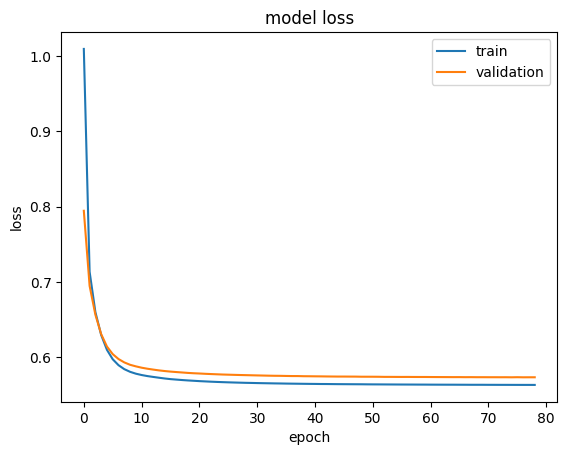

In [73]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [74]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test_encoded)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))

42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.3167    0.4565    0.3739       333
           1     0.6350    0.6081    0.6213       615
           2     0.6196    0.4202    0.5008       376

    accuracy                         0.5166      1324
   macro avg     0.5237    0.4949    0.4987      1324
weighted avg     0.5506    0.5166    0.5248      1324

